#  <center><span style="color:black"> Predicting eye status based on EEG data </style></center>
###  <center><span style="color:black"> Author : Khalil ZLAOUI </style></center>
###  <center><span style="color:black"> Year : 2016 </style></center>


Statistics are crutial in electroencephalogram (EEG) data analysis. Because EEG data are experiment specific, I chose to collect official data from the UCI (University of California Irvene). Many supervised learning techniques are used in EEG data analysis, such as GLM (generalized linear models), hierarchical bayesian models, SVM in case of binary classification, etc. One common approach is also to use Independent Component Analysis (ICA) to reduce signal noize and to reconstruct signal.

In practice, the selection of EEG features used to answer experimental questions is typically determined a priori. But the utility of machine learning was investigated as a computational framework for extracting the most relevant features from EEG data empirically.

I will be looking at EEG signals that tell me whether a patient's eye is open or closed. This is useful in science because it helps understand the brain, and what parts of the brain are at play. The data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset (https://www.emotiv.com/). The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analyzing the video frames. '1' indicates the eye-closed and '0' the eye-open state. All values are in chronological order with the first measured value at the top of the data.

In the following work I want to know whether EEG data can help understand which measurements explain the eye's status (open or closed), and whether I could predict an eye's status based on EEG data. The latter is a bit tricky because EEG data is noisy and also can be different from patient to patient. Also, I do not have the appropriate data to backtest any conclusions on other patients, so this part is disputable.

I will also explore subjects such as signal processing, because ultimately my data is made of continuous EEG measurements, and if I want to treat it as signal, it is not a good idea to shuffle it, since this implies loosing periodicity.

I decided to explore some supervised learning algorithms. I detail every step of my approach, including problems I face and how I intend to solve them. I will therefore be using different algorithms, trying to understand which are useful in a dataset like mine, how they compare, and how to finetune them.

Dataset Information can be found here : https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State#



## I- Visualizing Data
  * #### I.1- Major trends and jumps
  * #### I.2- Signal and noize

## II- Model Evaluation : can we make predictions?
  * #### Null Accuracy
  
- ### II.1- Linear Models

   ##### II.1.a -  Logistic regression (and cross validation)
   ##### II.1.b - Lasso
   ##### II.1.c- l1 Regularized Logistic Regression
  
- ### II.2- Support Vector Machines (SVM)

   ##### II.2.1- Linear SVC 
   ##### II.2.2- Linear SVC : Cross validation 
   ##### II.2.3- Tuning hyperparameters for SVC : Grid-search and Cross validation

- ### II.3- Random forests (RF)

- ### II.4- K nearest neighbors (KNN)
- ##### Tuning hyperparameters for KNN : Grid-search and Cross validation


## III- Can we improve prediction by reconstructing signal?  

   #### III.1- Independent Component Analysis (ICA)
   #### III.2- KNN post reconstructed signal :
   #### III.3- limitations for prediction :

## IV- Feature Selection
- #### Illustration : two dimensional SVC on 'Parietal 7' and 'Occipital 1' 

## Main conclusions




### Dataset cleaning

In [1]:
import pandas as pd
from pandas import Series

df=pd.read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff")

df=df[16:]
df= df.rename(columns={'@RELATION EEG_DATA': 'Data'})
df=df.ix[:,0]
df= pd.DataFrame([sub.split(",") for sub in df])
df.rename(columns=lambda x: "EEG"+str(x+1), inplace=True)
df.rename(columns={"EEG15": "Eye_Status"}, inplace=True)

df.rename(columns={"EEG1": "AF3"}, inplace=True)           # These letters are important because they follow the 10-20
df.rename(columns={"EEG2": "F7"}, inplace=True)            # system regarding scalp electrode location
df.rename(columns={"EEG3": "F3"}, inplace=True)
df.rename(columns={"EEG4": "FC5"}, inplace=True)
df.rename(columns={"EEG5": "T7"}, inplace=True)
df.rename(columns={"EEG6": "P7"}, inplace=True)
df.rename(columns={"EEG7": "O1"}, inplace=True)
df.rename(columns={"EEG8": "O2"}, inplace=True)
df.rename(columns={"EEG9": "P8"}, inplace=True)
df.rename(columns={"EEG10": "T8"}, inplace=True)
df.rename(columns={"EEG11": "FC6"}, inplace=True)
df.rename(columns={"EEG12": "F4"}, inplace=True)
df.rename(columns={"EEG13": "F8"}, inplace=True)
df.rename(columns={"EEG14": "AF4"}, inplace=True)


df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Eye_Status
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.9,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.1,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.9,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.9,4627.69,4210.77,4244.1,4212.82,4288.21,4632.82,4398.46,0


My database contains 14 features, one binary outcome variable (Eye_Status), and 14,980 observations

In [2]:
df.shape

(14980, 15)

### Train and Test

We see that there is enough data on each outcome category (number of 0 and 1).

In [3]:
df['Eye_Status'].value_counts()

0    8257
1    6723
Name: Eye_Status, dtype: int64

Scaling the Data:

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

df_scaled=df.ix[:,0:14]


scaler = preprocessing.StandardScaler().fit(df_scaled)
StandardScaler(copy=True, with_mean=True, with_std=True)
df_scaled=scaler.transform(df_scaled)                               
df_scaled=pd.DataFrame(df_scaled)

df_scaled.rename(columns=lambda x: "EEG"+str(x+1), inplace=True)
df_scaled.rename(columns={"EEG1": "AF3"}, inplace=True)           # These letters are important because they follow the 10-20
df_scaled.rename(columns={"EEG2": "F7"}, inplace=True)            # system regarding scalp electrode location
df_scaled.rename(columns={"EEG3": "F3"}, inplace=True)
df_scaled.rename(columns={"EEG4": "FC5"}, inplace=True)
df_scaled.rename(columns={"EEG5": "T7"}, inplace=True)
df_scaled.rename(columns={"EEG6": "P7"}, inplace=True)
df_scaled.rename(columns={"EEG7": "O1"}, inplace=True)
df_scaled.rename(columns={"EEG8": "O2"}, inplace=True)
df_scaled.rename(columns={"EEG9": "P8"}, inplace=True)
df_scaled.rename(columns={"EEG10": "T8"}, inplace=True)
df_scaled.rename(columns={"EEG11": "FC6"}, inplace=True)
df_scaled.rename(columns={"EEG12": "F4"}, inplace=True)
df_scaled.rename(columns={"EEG13": "F8"}, inplace=True)
df_scaled.rename(columns={"EEG14": "AF4"}, inplace=True)

df_scaled.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0.002934,-0.011704,0.567398,-0.003209,0.245236,-0.019788,-0.002930,0.852568,0.001509,0.187750,0.233510,0.030745,0.017127,-0.003834
1,0.001084,-0.112052,0.671390,-0.003111,0.008893,-0.019610,-0.002817,0.782241,-0.003771,-0.122109,0.138498,0.006192,0.014578,-0.005489
2,0.002316,-0.067429,0.705829,-0.001636,-0.138785,-0.020663,-0.002930,0.484886,-0.005213,-0.243529,0.111503,0.067815,0.011185,-0.004618
3,0.002730,0.044020,0.729013,-0.001734,0.053225,-0.021015,-0.002817,0.502297,-0.000649,0.106803,0.220012,0.203578,0.014156,-0.003399
4,0.001698,0.044020,0.636726,-0.002620,0.171253,-0.019610,-0.003152,0.397148,-0.003771,0.335977,0.274267,0.216095,0.014578,-0.003051


Splitting training and test sets:
I also check that my test and train data contain enough of both 0 and 1.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_scaled,df['Eye_Status'], test_size=0.3,random_state=1)
y_train.value_counts()
y_test.value_counts()

0    2479
1    2015
Name: Eye_Status, dtype: int64

But first, let's quickly visualise the data.

#  <span style="color:red">*** Visualizing Data  ***</style>

##  <span style="color:darkblue">Major trends and jumps [samples]</style>

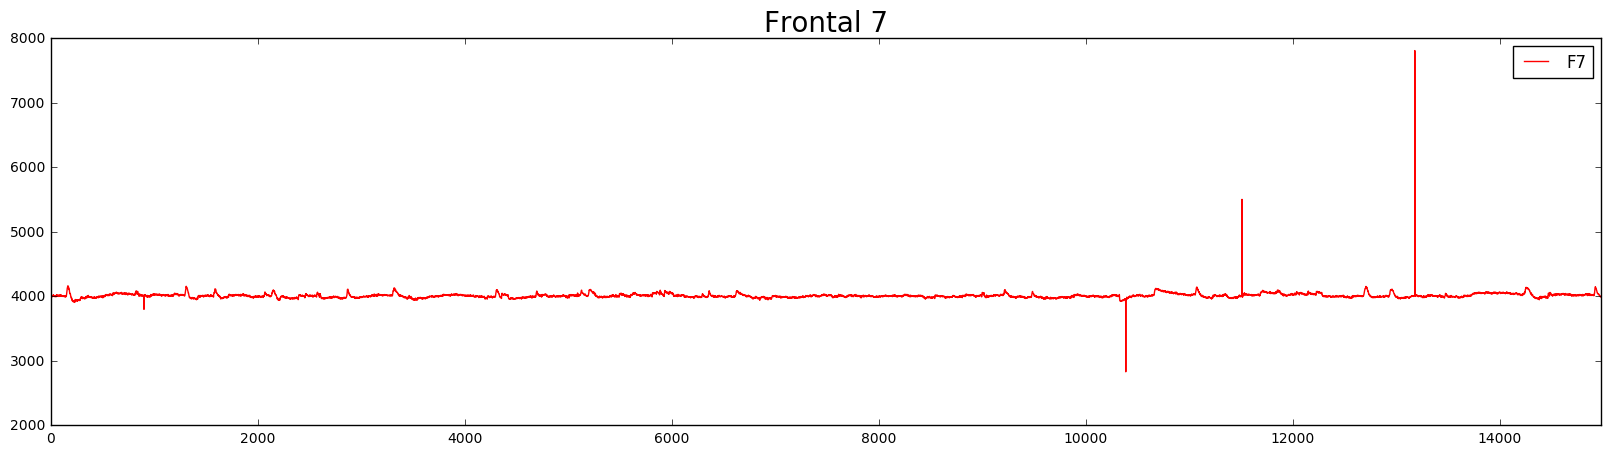

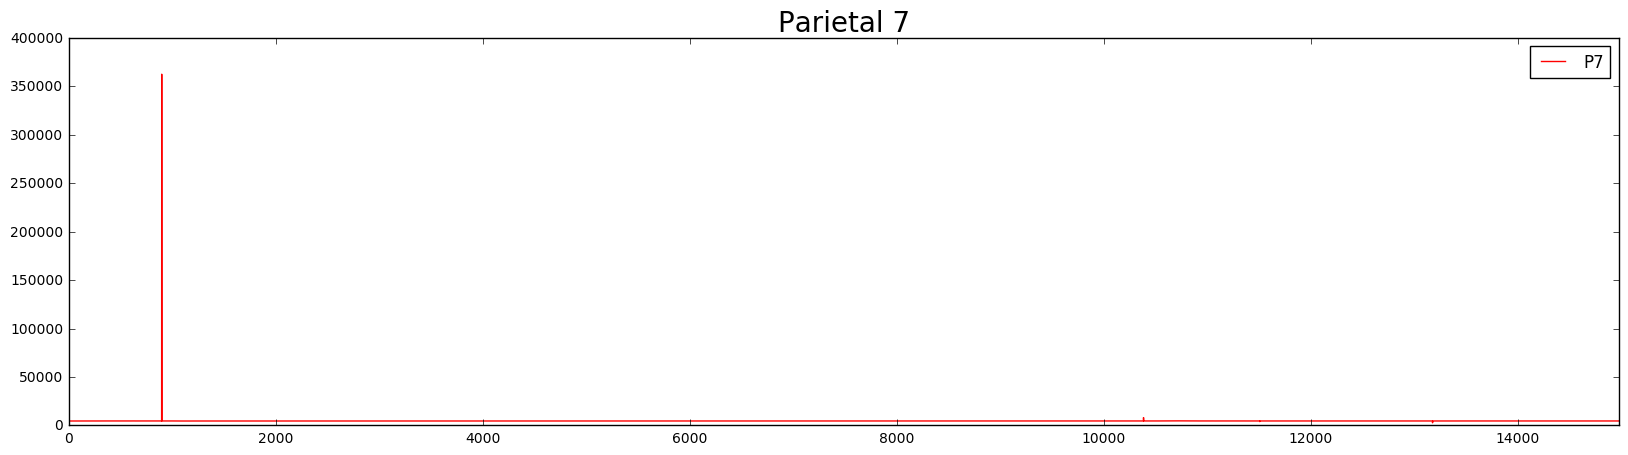

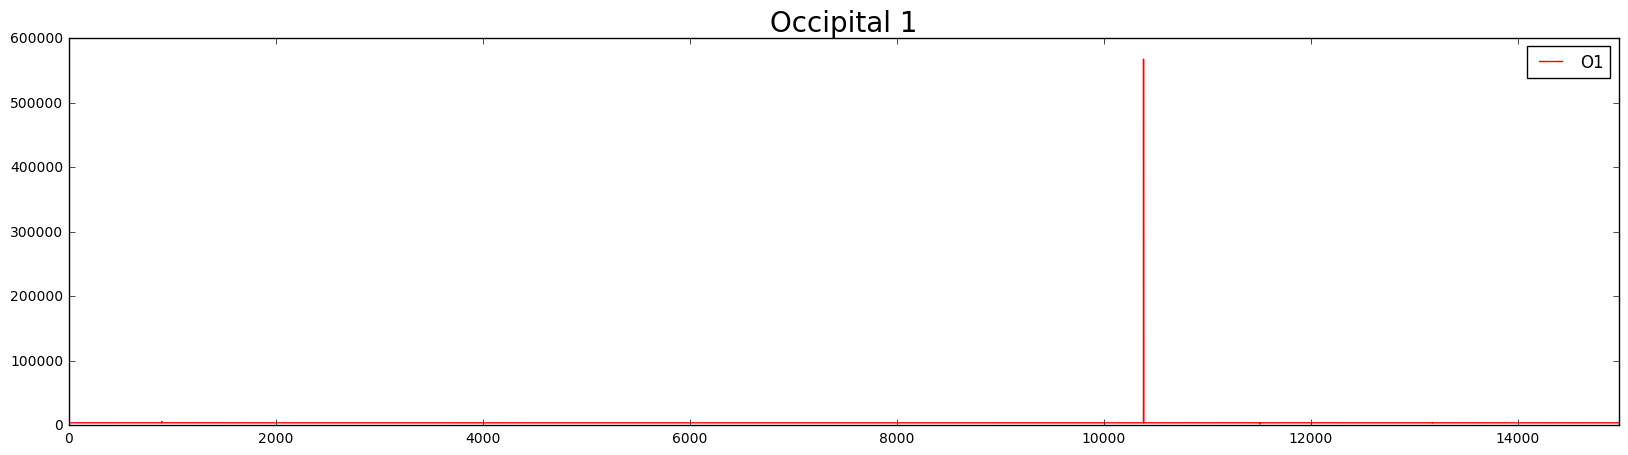

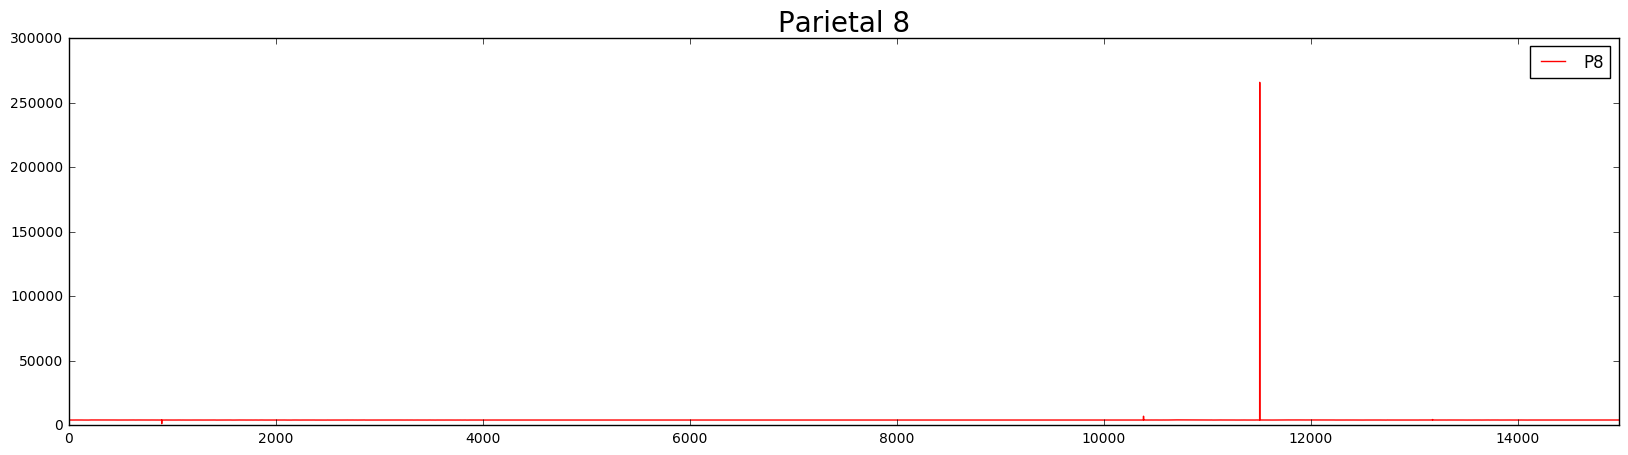

In [587]:
import pandas as pd
%matplotlib inline


Plot1=pd.DataFrame((df.ix[0:15000,1]))
Plot1=Plot1.astype('float').plot(figsize=(20,5),color='red')
Plot1.set_title('Frontal 7',fontsize=20)

Plot5=pd.DataFrame((df.ix[0:15000,5]))
Plot5=Plot5.astype('float').plot(figsize=(20,5),color='red')
Plot5.set_title('Parietal 7',fontsize=20)

Plot6=pd.DataFrame((df.ix[0:15000,6]))
Plot6=Plot6.astype('float').plot(figsize=(20,5),color='red')
Plot6.set_title('Occipital 1',fontsize=20)

Plot8=pd.DataFrame((df.ix[0:15000,8]))
Plot8=Plot8.astype('float').plot(figsize=(20,5),color='red')
Plot8.set_title('Parietal 8',fontsize=20)

It seems that EEG measurements fluctuate around 4000µV. However spikes can get them around 1 000 000µV (i.e 1 Volt).

##  <span style="color:darkblue">Signal and noize [samples]</style>

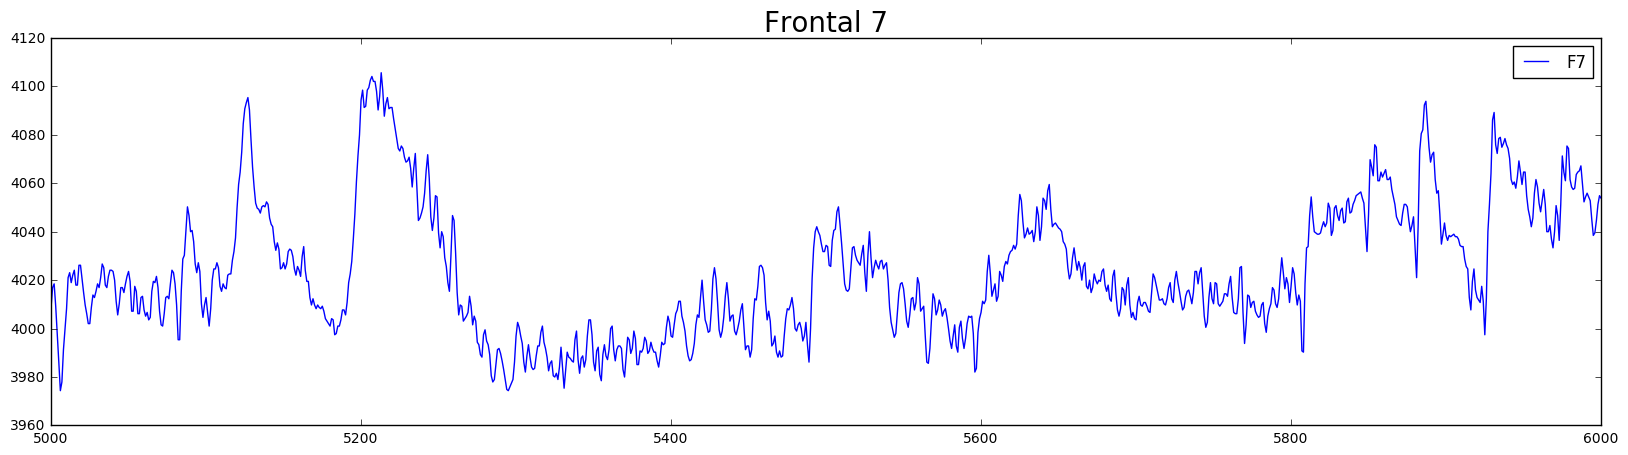

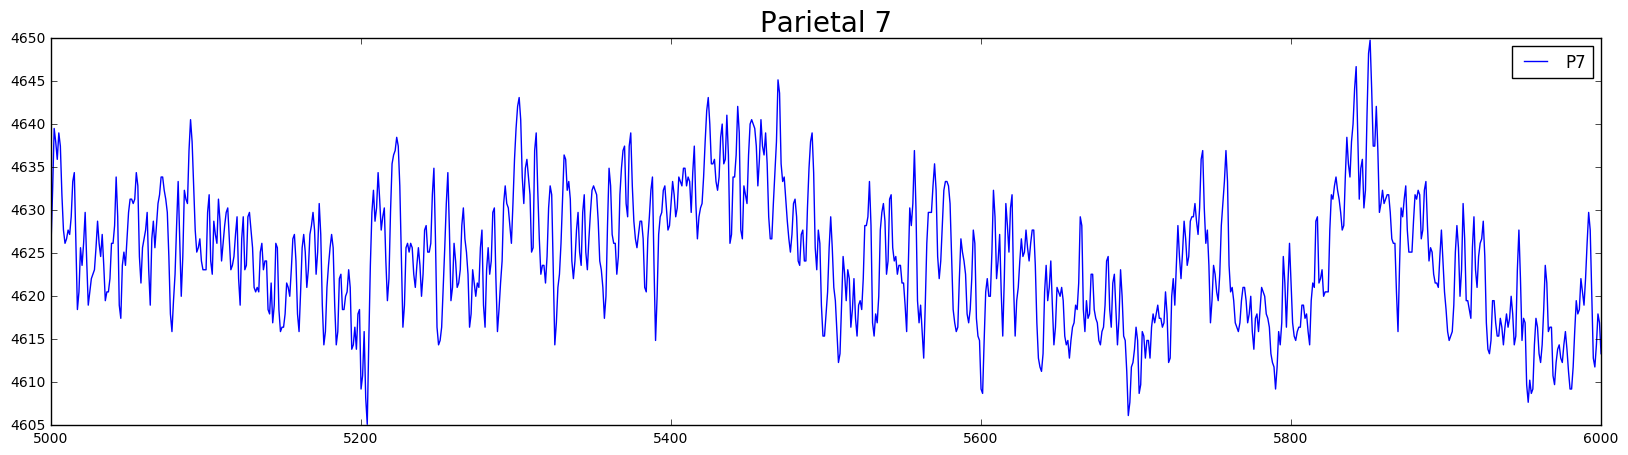

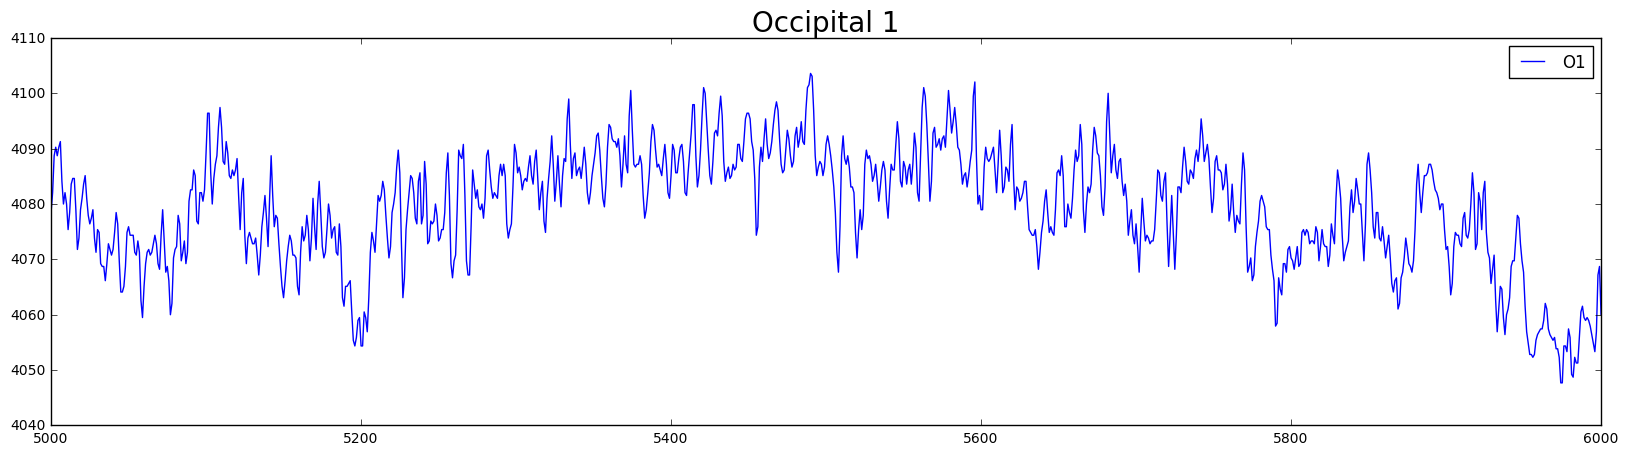

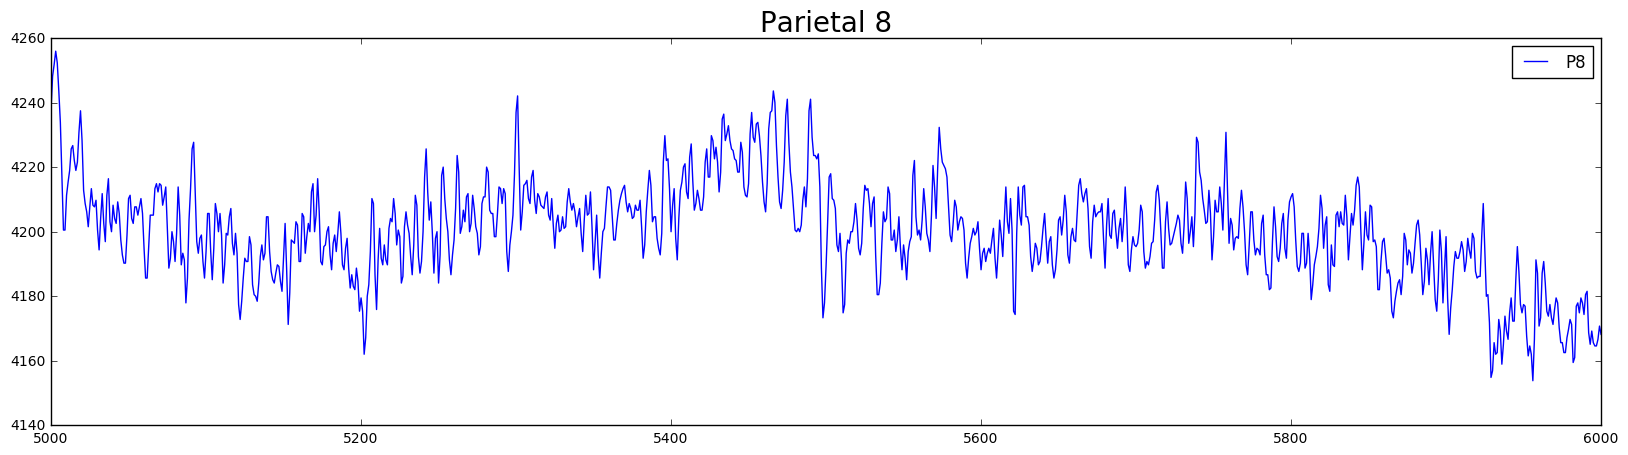

In [584]:

Plot1=pd.DataFrame((df.ix[5000:6000,1]))
Plot1=Plot1.astype('float').plot(figsize=(20,5))
Plot1.set_title('Frontal 7',fontsize=20)

Plot5=pd.DataFrame((df.ix[5000:6000,5]))
Plot5=Plot5.astype('float').plot(figsize=(20,5))
Plot5.set_title('Parietal 7',fontsize=20)

Plot6=pd.DataFrame((df.ix[5000:6000,6]))
Plot6=Plot6.astype('float').plot(figsize=(20,5))
Plot6.set_title('Occipital 1',fontsize=20)

Plot8=pd.DataFrame((df.ix[5000:6000,8]))
Plot8=Plot8.astype('float').plot(figsize=(20,5))
Plot8.set_title('Parietal 8',fontsize=20)

We also notice as expected that the data is a signal and can be noizy when zoomed in.

#  <span style="color:red">*** Model Evaluation : can we make predictions?  ***</style>

In this part, I want to know based on the patient's EEG data whether his eye is open or closed. This should be feasable because the data belongs to one patient and should have some regularity. I chose to predict the eye status with supervised machine learning algorithms. Therefore, the following models are solely of this kind.

##  <span style="color:darkblue">Null Accuracy</style>

The null accuracy of a model is a benchmark. Indeed, if we were to choose a dummy model to make predictions, we could achieve this accuracy level.

In [597]:
NullAc=y_test.value_counts()
NullAc=pd.DataFrame(NullAc)
NullAc=2015/NullAc.sum()
print("Null accuracy: ",1-float(NullAc))

Null accuracy:  0.5516243880729862


If we always predicted 0 (eye open), we would have an accuracy of 55% in this dataset.

##  <span style="color:darkblue">Linear Models</style>

### 1A -  Logistic regression (and cross validation) :
Why logistic resgression ? In practice logistic regression is used when the number of features is large relative to the number of training examples. Therefore I am not expecting good results from the logistic regression.

In [598]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
logreg=LogisticRegression()
scores = cross_val_score(logreg, X_train, y_train, cv=5,scoring='accuracy')
print("the score's mean is : ",scores.mean())

the score's mean is :  0.584304663111


As expected the score is poor.

### 1B - Lasso :

Why Lasso? Lasso is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. Therefore it is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. For this reason, the Lasso and its variants are fundamental to the field of compressed sensing.

In [418]:
import math
import numpy as np

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn import metrics

Al = 0.0001
lasso = Lasso(alpha=Al, normalize='true')
lasso.fit(X_train, y_train)

y_pred_lasso=lasso.predict(X_test)

y_pred_lasso=pd.DataFrame(y_pred_lasso)
y_pred_lasso=y_pred_lasso.apply(np.round)      # I have to round to obtain a categorical output

print("Accuracy on test data : %f" % metrics.accuracy_score(y_test,y_pred_lasso))

Accuracy on test data : 0.000000


The model is really not a fit, or else I am doing something wrong.

### 1C- l1 Regularized Logistic Regression : cross-validation :

I want to try this as a last GLM solution.

In [419]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
scores = cross_val_score(logreg, X_train, y_train, cv=5,scoring='accuracy')
print("the score's mean is : ",scores.mean())

the score's mean is :  0.591834098633


It seems that these regression models are not a fit for my data. If I only care about prediction error and don't care about interpretability, I should not bother using a linear regression model. Therefore I am moving on to other learning algorithms.

##  <span style="color:darkblue">Support Vector Machines (SVM)</style>

It is a very popular classifier that transforms the data before seperating it and can be non linear.

### 1- Linear SVC :
From Sklearn : SVC is "hard to scale to dataset with more than a couple of 10000 samples". Testing this on my own.

In [599]:
from sklearn.svm import SVC
clf = SVC(kernel='linear',gamma=0.001,C=1)
clf.fit(X_train, y_train)
accuracy=clf.score(X_test,y_test)
accuracy

0.60725411659991102

Model accuracy is poor. NB : can be rewritten as following:

In [421]:
from sklearn import metrics
y_pred_SVC=clf.predict(X_test)
metrics.accuracy_score(y_test,y_pred_SVC)

0.60725411659991102

### 2- Linear SVC : Cross validation :

In [422]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=5,scoring='accuracy')
print("the score's mean is : ",scores.mean())

the score's mean is :  0.608811008667


The score is indeed low. I will now try tuning hyperparameters of an SVM. Since I have a large number of training examples, and a small/average number of features, my data should be appropriate for SVM with Gaussian Kernel.

I use the following paper to possibly get the best results from SVM before moving on to other learning techniques:

http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

### 3- Tuning hyperparameters for SVC : Grid-search and Cross validation :
#### Coarse grid
The coarse grid is not the finest by definition but enables a quicker identification of the region where the best Kernel parameters lie. 

NB: Grid-search is time consuming.

In [423]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'),'C':[0.1, 1, 5, 10],'gamma':[0.001, 0.0001]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 5, 10], 'kernel': ('linear', 'rbf'), 'gamma': [0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [424]:
Tunedclf=pd.DataFrame(clf.cv_results_)

In [425]:
clf.best_estimator_.score(X_test, y_test)

0.61815754339118822

The best estimator gives an accuracy of 0.61. I will therefore move on to other types of learning algorithms.

###  TODO : 3- Quadratic Discriminant Analysis :

Why QDA ? There might be a dimensionality problem with my data, and some of the EEG measurements might blurr the outcome. QDA is attractive because it has a closed-form solution that can be easily computed, and there are no hyperparameters to tune. I could have used PCA, but in contrast, QDA is a supervised method.

With plot : http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

##  <span style="color:darkblue">Random forests (RF)</style>

Why RF? Random forests have become extremely popular in neurosciences. They are not only used for prediction, but also to assess variable importance, which is the bulk of our problem. 

In [611]:
from sklearn.ensemble import RandomForestClassifier
RandomFclf = RandomForestClassifier(n_estimators=100)
RandomFclf = RandomFclf.fit(X_train, y_train)

prediction_RF = RandomFclf.predict(X_test)

RandomFclf.score(X_test,y_test)

0.93324432576769023

I get pretty good results with random forests.

What prediction mistakes are me making ? let us have a look at ROC and the confusion matrix.

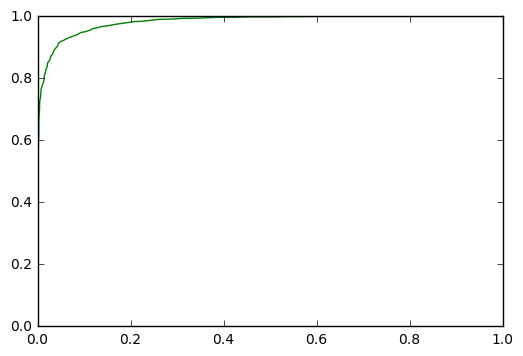

In [625]:
from pandas import Series
y_pred_prob=RandomFclf.predict_proba(X_test)[:, 1]
y_test=Series.tolist(y_test)
y_test=[float(i) for i in y_test]
fpr,tpr,thresh=metrics.roc_curve(y_test,y_pred_prob)
ROCplot=plt.plot(fpr,tpr,color='green')

In [613]:
prediction_RF = [int(x) for x in prediction_RF]
prediction_RF
metrics.confusion_matrix(y_test,prediction_RF)

array([[2374,  105],
       [ 195, 1820]])

We see that there is no clear bias towards one or the other eye state, which is good news.

Can we tell what features are most important for the classification?

In [454]:
RandomFclf.feature_importances_

array([ 0.0748319 ,  0.09431245,  0.05170902,  0.06063115,  0.05212589,
        0.1058271 ,  0.11858133,  0.05490486,  0.04514075,  0.0582888 ,
        0.06092444,  0.06317189,  0.07912116,  0.08042925])

We see that features F7, P7 and O1 are the most important, i.e. that measures from the Frontal 7, Parietal 7 and Occipital 1 electrodes matter more in prediction.
It seems we can look at reducing the dimensionality of our data, which I will look to do later on.

### TODO  : Extremely Randomized Trees

##  <span style="color:darkblue">K nearest neighbors (KNN)</style>:

Why KNN? KNN is an non parametric lazy learning algorithm. This means that it does not make any assumptions on the underlying data distribution. This could be pretty useful , as we saw that our data is not efficiently linearly separable. In that sense it differs from the learning algorithms that we have used before, and therefore I am interested in seeing how it performs on my data.



In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)

knn_y_pred=knn.predict(X_test)
metrics.accuracy_score(knn_y_pred,y_test)

0.82087227414330222

The result is not bad. There is however room for improvement so I will look to tune its hyperparameters.

### Tuning hyperparameters for KNN : Grid-search and Cross validation :

In [20]:
from sklearn.cross_validation import cross_val_score
scores_knn=cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy')

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
scores_knn.mean()

0.81356113436867938

In [22]:
k_range=range(1,30)
k_scores=[]

for k in k_range:
    knncv=KNeighborsClassifier(n_neighbors=k)
    scores_knn=cross_val_score(knncv,X_train,y_train,cv=10,scoring='accuracy')
    k_scores.append(scores_knn.mean())
    
print(k_scores)

[0.82119035785236605, 0.80450361338402288, 0.82157176435365042, 0.81718744964566137, 0.82100088311763919, 0.81566118828788825, 0.82119035629300574, 0.81632721717624823, 0.81794717424879548, 0.81356113436867938, 0.81222725647212446, 0.80907994735600075, 0.81203732571118081, 0.80764946692406492, 0.8092694222639899, 0.80507367699552179, 0.80640873706034277, 0.80278514667861478, 0.80240374087037925, 0.80221371932002195, 0.80164020189902341, 0.80125915872865716, 0.8004957996035067, 0.79944890895034615, 0.79754096664390006, 0.79773207888006048, 0.79725434394425942, 0.79668337105252307, 0.79620609041031609]


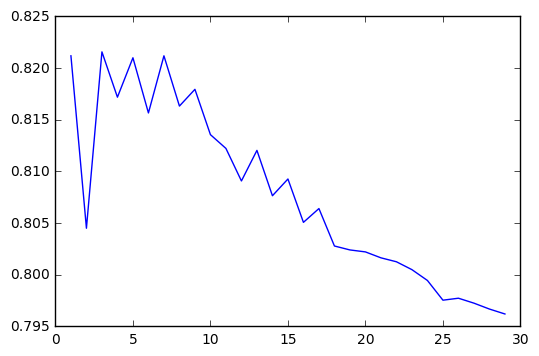

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range,k_scores)

Our best estimator will be with k=7 in this case. Higher values of k come with lower variance so we pick the highest k with highest score.

Prediction is not bad but is not really good either. Random forests are preferred.

#  <span style="color:red">*** Can we improve prediction by reconstructing signal?  ***</style>

### Independent Component Analysis (ICA)

ICA is very commonly used in pre-processing when dealing with EEG data.

Why ICA ? When the statistical independence assumption is correct, blind ICA separation of a mixed signal gives very good results. Note that we can implement this algorithm because our data are continous.

In [458]:
from sklearn.decomposition import FastICA
ica=FastICA()
Signal=ica.fit_transform(df.ix[:,0:14])                                # NB: features are unscaled
Matrix=ica.mixing_
Matrix=pd.DataFrame(Matrix)
ReconstructedSignal=pd.DataFrame(ica.fit_transform(df.ix[:,0:14]))    # Reconstruct signals

### KNN post reconstructed signal :

In [459]:
from sklearn.model_selection import train_test_split

X_Reconstr_train, X_Reconstr_test, y_Reconstr_train, y_Reconstr_test = train_test_split(ReconstructedSignal,df['Eye_Status'], test_size=0.3)

In [460]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_Reconstr_train,y_Reconstr_train)

knn_y_pred=knn.predict(X_Reconstr_test)
metrics.accuracy_score(knn_y_pred,y_Reconstr_test)

0.93769470404984423

It seems that ICA has improved our prediction reliability for KNN : our prediction accurcay goes from 82% with standard KNN to 94% with KNN on reconstructed signal. Essentially what this means is that our data is more easily seperable once the signal is treated. Is it, however a good approach for prediction?

### limitations for prediction :

Everything seems to work well with reconstructed signal. But I see a limitation to what I am doing.
I am essentially using ICA on the whole set, and then dividing it into train and test.
It all comes down to what I want to do. If I want to understand what drives the eye to be open or close (i.e. which EEG feature is important, then what I am doing is fine as long as I identify those features). However, if I want to predict an eye's status given a new set of EEG, then I should do the ICA independently on the train set and test set. So this is what I will do now, to see if I loose accuracy by doing so.

Important : I cannot use train_test_split because this will shuffle the data, which is continuous (it is a signal). Therefore I will split data arbitrarily myself, making the assumption that the signals are from two independent measurements (which of course they aren't). Although questionable, this method might work on a new patient if EEG data related to the eye status are stable from one person to another in terms of electric signal and measurements.

In [461]:
from sklearn.decomposition import FastICA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Step 1 : reconstructing signal for train and test data :

X_train=(df.ix[0:12430,0:14])
X_test=(df.ix[12431:14980,0:14])

y_train=(df['Eye_Status'].ix[0:12430])
y_test=(df['Eye_Status'].ix[12431:14980])

ica=FastICA()
X_train_Signal=ica.fit_transform(X_train)
X_train_Reconstructed=pd.DataFrame(X_train_Signal)                # Reconstruct signals
X_test_Reconstructed=pd.DataFrame(ica.fit_transform(X_test))      # Reconstruct signals


# Step 2 : Prediction using KNN :

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_Reconstructed,y_train)

knn_y_pred=knn.predict(X_test_Reconstructed)
metrics.accuracy_score(knn_y_pred,y_test)

# Step 2bis : Prediction using RF :

RandomFclf = RandomForestClassifier(n_estimators=100)
RandomFclf.fit(X_train_Reconstructed, y_train)

RF_y_pred = RandomFclf.predict(X_test_Reconstructed)
metrics.accuracy_score(RF_y_pred,y_test)

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


0.4182032169478227

It seems that this method is not robust for prediction : if we were to predict eye status on another patient based on similar EEG data, this is not a good prediction methodology. I will hence stick to random forests without signal treatment.

#  <span style="color:red">*** Feature Selection ***</style>

Feature selection is important in my problem, and in general in knowledge discovery. It will help me tell which features actually matter, i.e. in practice, which parts of the brain send signals to open and close the eye. I noticed earlier with random forests that some features were important at discriminating data. These were F7, P7 and O1. It seems therefore that some EEG measurements are useless at prediction, while other are paramount at telling the eye status.

"The objective of variable selection is three-fold: improving the prediction performance of the predictors, providing faster and more cost-effective predictors, and providing a better understanding of the underlying process that generated the data."

Guyon and Elisseeff in “An Introduction to Variable and Feature Selection”

In [462]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
X=df.ix[:,0:14]
y=df['Eye_Status']

clf = clf.fit(X,y)
clf.feature_importances_  

array([ 0.07858847,  0.08244915,  0.05526964,  0.06440187,  0.05719001,
        0.10166519,  0.11802355,  0.05552258,  0.04858196,  0.05857718,
        0.06263355,  0.06165813,  0.07260067,  0.08283805])

Again, we have the confirmation that the same electrodes identified earlier give more important signals and therefore we could reduce the dimensionality of our data.

In [463]:
from sklearn.model_selection import train_test_split

model = SelectFromModel(clf, prefit=True)

X_new = model.transform(X)
X_new=pd.DataFrame(X_new)

X_train, X_test, y_train, y_test = train_test_split(X_new,df['Eye_Status'], test_size=0.3)


In [464]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

RandomFclf = RandomForestClassifier(n_estimators=100)
RandomFclf = RandomFclf.fit(X_train, y_train)

prediction = RandomFclf.predict(X_test)
prediction

print("RF score: ",metrics.accuracy_score(y_test,prediction))

RF score:  0.861815754339


In [465]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

Knnprediction = knn.predict(X_test)
Knnprediction

print("knn score: ",metrics.accuracy_score(y_test,prediction))

knn score:  0.861815754339


In [466]:
from sklearn.svm import SVC
clfSVC = SVC(kernel='rbf',gamma=0.01,C=1)
clfSVC.fit(X_train, y_train)

Svcprediction = clfSVC.predict(X_test)

print("SVM rbf score: ",metrics.accuracy_score(y_test,Svcprediction))

SVM rbf score:  0.894748553627


#### We see that reducing dimensionality via feature selection is a very powerful way to improve some models, especially SVC.

##  <span style="color:darkblue">Illustration : Two-dimensional SVC on 'Parietal 7' and 'Occipital 1' </style>:

In [6]:
from sklearn.svm import SVC

X_DfSVC2dim=df.ix[:,5:7]   # 5 and 6 for P7 and O1
y_DfSVC2dim=df['Eye_Status']

clfSVC = SVC(kernel='rbf',gamma=0.01,C=1)
clfSVC.fit(X_DfSVC2dim, y_DfSVC2dim)

print("SVM rbf score: ",clfSVC.score(X_DfSVC2dim,y_DfSVC2dim))

SVM rbf score:  0.691655540721


In [675]:
X_DfSVC2dim.head()

,P7,O1
0,4586.15,4096.92
1,4586.67,4097.44
2,4583.59,4096.92
3,4582.56,4097.44
4,4586.67,4095.9


Reminder : This is not the best score since we reduce the dimensions to 2 but we are now doing this for illustration.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

h = 10

# Creation of a mesh to plot in
x_min=float(X_DfSVC2dim.ix[:,0].values.min())-10
x_max=float(X_DfSVC2dim.ix[:,0].values.max())+10

y_min=float(X_DfSVC2dim.ix[:,1].min())-10
y_max=float(X_DfSVC2dim.ix[:,1].max())+10


xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))


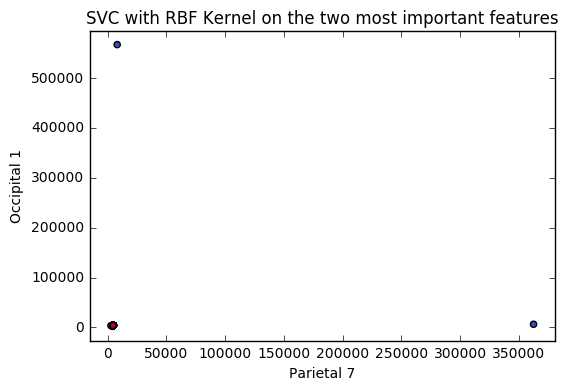

In [9]:
plt.subplot(1, 1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
Z = clfSVC.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X_DfSVC2dim.ix[:,0].astype('float'), X_DfSVC2dim.ix[:,1].astype('float'), c=y_DfSVC2dim, cmap=plt.cm.coolwarm)
plt.xlabel('Parietal 7')
plt.ylabel('Occipital 1')
plt.title('SVC with RBF Kernel on the two most important features')
plt.show()

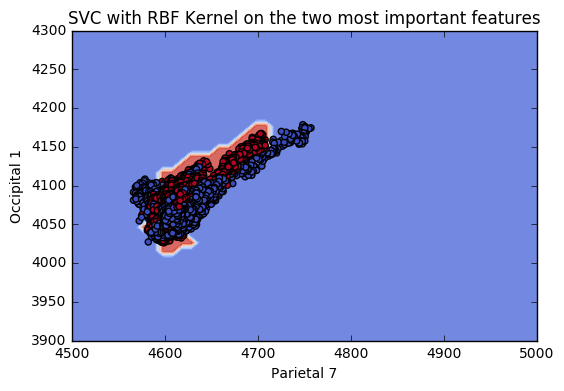

In [13]:
plt.subplot(1, 1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
Z = clfSVC.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X_DfSVC2dim.ix[:,0].astype('float'), X_DfSVC2dim.ix[:,1].astype('float'), c=y_DfSVC2dim, cmap=plt.cm.coolwarm)
plt.xlabel('Parietal 7')
plt.ylabel('Occipital 1')
plt.title('SVC with RBF Kernel on the two most important features')
plt.xlim(4500,5000)
plt.ylim(3900,4300)
plt.show()

#  <span style="color:red">*** Main conclusions***</style>

## Approach
My approach consisted in looking at supervised machine learning algorithms to understand which areas of the brain were the most active when the patient opened and closed his eyes, and to try to predict the eye's status based on his EEG. Prediction was feasable, and I could identify that electrodes placed in Occipital 1 and Parietal 7 were the most important in predicting the eye status.

## Signal treatment

I reconstructed signal through independent component analysis (ICA) which worked very well on the whole dataset but was not very useful if we were to use the model for prediction.

## Dimension reduction and Feature selection
I had noticed since the beginning when I used random forests that some measurements were more important than others in determining the patient's eye status. 

Feature selection drastically improved some models, especially the SVM models.
Once again, it appeared that Parietal7 and Occipital1 measurements played a particular role in defining the eye's status.


## Model comparison for prediction

A chart is worth a thousand words :

NB : Chart is before feature selection

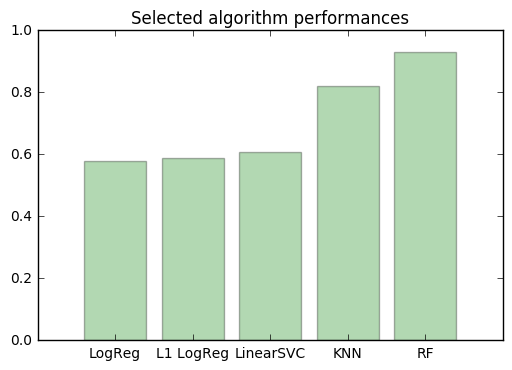

In [715]:
MLAlg=('LogReg','L1 LogReg','LinearSVC','KNN','RF')
MLAlgPerf=[0.58,0.59,0.607,0.82,0.93]
ypos=np.arange(len(MLAlg))

plt.bar(ypos,MLAlgPerf,align='center',alpha=0.3,color='green')
plt.xticks(ypos,MLAlg)
plt.title('Selected algorithm performances')
plt.show()

### My results coincide with Suendermann's results his paper http://suendermann.com/su/pdf/aihls2013.pdf, where he goes further and finds an optimal classifier for EEG : the KStar algorithm.

# Sources:

http://suendermann.com/su/pdf/aihls2013.pdf

http://scikit-learn.org/stable/index.html

http://doc.ml.tu-berlin.de/publications/publications/MueTanDorKraCurBla08.pdf

http://scikit-learn.org/stable/modules/cross_validation.html

https://www.youtube.com/watch?v=6dbrR-WymjI

https://www.youtube.com/watch?v=elojMnjn4kk&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A

http://machinelearningmastery.com/an-introduction-to-feature-selection/

https://www.youtube.com/watch?v=85dtiMz9tSo

http://scikit-learn.org/stable/modules/manifold.html